In [240]:
import pandas as pd
import numpy as np
import seaborn as sn
import os as os
import glob as glob
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Read in data

- Read in from ./data directory
    - Expects the name to be in the format of `YYYY data.csv`
    - Add year to data set
- Join together



In [241]:
data = {}
for f in glob.glob("data/*.csv"):
    # find year for each file
    yr = int(f[5:9])
    
    # read in CSV data files
    print(f)
    data[yr] = pd.read_csv(f, index_col=0)

    # add year to current DataFrame
    data[yr]['year'] = yr

data/2014 data.csv
data/2015 data.csv
data/2016 data.csv
data/2017 data.csv
data/2018 data.csv
data/2019 data.csv
data/2021 data.csv


In [242]:
# join datasets together
df = pd.DataFrame()
for k in data.keys():
    df = df.append(data[k])
df.reset_index(drop=True, inplace=True)

In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Team                             478 non-null    object 
 1   Conference                       478 non-null    object 
 2   Region                           478 non-null    object 
 3   Cinderella                       478 non-null    float64
 4   Conference Tournament Champion   478 non-null    float64
 5   Number of Tournament Wins        478 non-null    float64
 6   Made Tournament Previous Year    478 non-null    float64
 7   Game Count                       478 non-null    float64
 8   Wins                             478 non-null    float64
 9   Losses                           478 non-null    float64
 10  3-Pointers Made                  478 non-null    float64
 11  3-Pointers Attempted             478 non-null    float64
 12  3-Point Percentage    

## Analyze Data

- Look at how Quad 1 Wins/Losses compares to Wins/Losses against Top 25 Teams

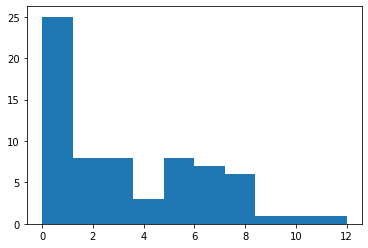

In [244]:
# plt.figure(figsize=(8,6))
plt.hist(df['Quad 1 Wins'])
plt.locator_params(axis='x', nbins=df['Quad 1 Wins'].max())
plt.show()

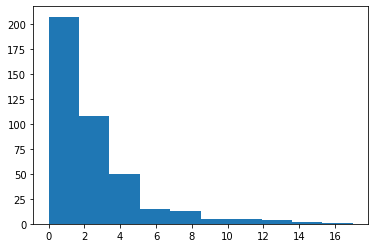

In [245]:
# plt.figure(figsize=(8,6))
plt.hist(df["Wins Against Top 25 RPI Teams"])
plt.locator_params(axis='x', nbins=df['Wins Against Top 25 RPI Teams'].max())
plt.show()

In [246]:
df['Wins Against Top 25 RPI Teams'].describe()

count    410.000000
mean       2.260976
std        2.781829
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       17.000000
Name: Wins Against Top 25 RPI Teams, dtype: float64

In [247]:
df['Quad 1 Wins'].describe()

count    68.000000
mean      3.235294
std       3.129626
min       0.000000
25%       0.000000
50%       3.000000
75%       5.000000
max      12.000000
Name: Quad 1 Wins, dtype: float64

In [248]:
ttest_ind(df.loc[~df['Quad 1 Wins'].isna(),'Quad 1 Wins'], df.loc[~df['Wins Against Top 25 RPI Teams'].isna(),'Wins Against Top 25 RPI Teams'], alternative='larger')

(2.6262174237947327, 0.004456074349035354, 476.0)

It would appear that the Quad 1 Wins and Wins Against Top 25 RPI Teams have significantly different means, though their distributions look similar. We are going to Standard Scale both columns then concatenate them together

## Clean Data

- Apply Standard scaling to all data
- OHE Region
- Drop Conference
- Drop Conference Tournament Champions
- Drop Total Points, Total Opp Points, Total Scoring Differential
- Apply hashing function to Team?
    - Sort names by how well they performed each year, then assign them a number, 1-$n$, then MinMax Scale

### Smaller Model

- Same as above
- Apply PCA to reduce feature count
- Handpick some features

In [249]:
def create_scaler(data: pd.DataFrame, column: str, transform=False):
    """Create and return a fitted standard scaler. Transform in place if True"""
    sclr = StandardScaler().fit(data[[column]])
    if transform:
        data[column] = sclr.transform(df[[column]])
    return sclr

In [250]:
std_sclrs = dict()

In [251]:
# Team
# drop, don't try encoding
df.drop(columns=['Team'], inplace=True)

In [252]:
# Conference
# drop
df.drop(columns=['Conference'], inplace=True)

In [253]:
# Region
# dummy columns
df = df.join(pd.get_dummies(df['Region'], prefix="Region"))
df.drop(columns=['Region'], inplace=True)

In [254]:
# Cinderella
# no action, is target data

In [255]:
# Conference Tournament Champion
# drop
df.drop(columns=['Conference Tournament Champion'], inplace=True)

In [256]:
# Number of Tournament Wins
# no action, is target data

In [257]:
# Made Tournament Previous Year
# drop
df.drop(columns=['Made Tournament Previous Year'], inplace=True)

In [258]:
# year
# drop
df.drop(columns=['year'], inplace=True)

In [259]:
# Columns to scale
to_scale=['Game Count', 'Wins',
       'Losses', '3-Pointers Made', '3-Pointers Attempted',
       '3-Point Percentage', 'Free Throws Made', 'Free Throws Attempted',
       'Free Throw Percentage', 'Rebounds', "Opponent's Rebounds",
       'Rebound Differential', 'Offensive Rebounds', 'Assists', 'Turnovers',
       'Assist to Turnover Ratio', 'ESPN Strength of Schedule',
       'Wins Against Top 25 RPI Teams', 'Losses Against Top 25 RPI Teams',
       'Total Points', 'Average PPG', 'Total Opp Points', 'Average Opp PPG',
       'Total Scoring Differential', 'Scoring Differential Per Game',
       'Quad 1 Wins', 'Quad 1 Losses']

for c in to_scale:
    std_sclrs[c] = create_scaler(data=df, column=c, transform=True)

In [260]:
# create new column to combine Wins/Losses Against Top 25 RPI Teams and Quad 1 Wins/Losses
df['Wins vs Top Teams'] = np.NaN
df['Wins vs Top Teams'].fillna(df['Wins Against Top 25 RPI Teams'], inplace=True)
df['Wins vs Top Teams'].fillna(df['Quad 1 Wins'], inplace=True)
df.drop(columns=['Wins Against Top 25 RPI Teams','Quad 1 Wins'], inplace=True)

df['Losses vs Top Teams'] = np.NaN
df['Losses vs Top Teams'].fillna(df['Losses Against Top 25 RPI Teams'], inplace=True)
df['Losses vs Top Teams'].fillna(df['Quad 1 Losses'], inplace=True)
df.drop(columns=['Losses Against Top 25 RPI Teams', 'Quad 1 Losses'], inplace=True)

In [261]:
df.describe()

,Cinderella,Number of Tournament Wins,Game Count,Wins,Losses,3-Pointers Made,3-Pointers Attempted,3-Point Percentage,Free Throws Made,Free Throws Attempted,...,Total Opp Points,Average Opp PPG,Total Scoring Differential,Scoring Differential Per Game,Region_East,Region_Midwest,Region_South,Region_West,Wins vs Top Teams,Losses vs Top Teams
count,478.000000,478.000000,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,...,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,478.000000,478.000000,478.000000,478.000000,4.780000e+02,4.780000e+02
mean,0.531381,0.928870,3.567579e-16,-3.418929e-16,1.858114e-16,-2.081088e-16,2.229737e-16,-9.402056e-16,5.945964e-17,2.081088e-16,...,8.770297e-16,1.724330e-15,-1.337842e-16,7.711172e-17,0.257322,0.248954,0.242678,0.251046,5.945964e-17,-4.459473e-17
std,0.499537,1.325117,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,...,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,0.437616,0.432860,0.429151,0.434069,1.001048e+00,1.001048e+00
min,0.000000,0.000000,-5.375902e+00,-2.792627e+00,-2.551177e+00,-2.584630e+00,-2.699818e+00,-3.364914e+00,-2.968725e+00,-3.085279e+00,...,-4.244440e+00,-3.266895e+00,-2.820441e+00,-2.856254e+00,0.000000,0.000000,0.000000,0.000000,-1.041450e+00,-1.246276e+00
25%,0.000000,0.000000,6.961964e-02,-7.995316e-01,-7.639823e-01,-7.226398e-01,-7.123836e-01,-7.027664e-01,-6.225124e-01,-6.125734e-01,...,-4.936791e-01,-6.773698e-01,-7.162061e-01,-7.178009e-01,0.000000,0.000000,0.000000,0.000000,-8.137589e-01,-8.426634e-01
50%,1.000000,0.000000,3.721486e-01,-5.212070e-02,-1.682506e-01,-6.160818e-02,-4.426743e-02,-4.466796e-03,6.888350e-02,7.789579e-02,...,1.382788e-01,7.314533e-02,-7.939825e-02,-7.217637e-02,0.000000,0.000000,0.000000,0.000000,-3.976446e-01,-3.543911e-02
75%,1.000000,1.000000,6.746776e-01,6.952902e-01,7.253470e-01,6.852062e-01,6.492203e-01,6.772386e-01,6.469358e-01,6.857447e-01,...,6.625275e-01,6.325301e-01,6.231669e-01,5.951784e-01,1.000000,0.000000,0.000000,0.750000,2.659859e-01,7.717851e-01
max,1.000000,6.000000,1.279736e+00,2.688386e+00,3.108274e+00,3.188044e+00,3.338599e+00,2.863802e+00,2.607780e+00,2.792561e+00,...,2.462130e+00,2.876394e+00,3.603012e+00,3.517945e+00,1.000000,1.000000,1.000000,1.000000,5.304795e+00,3.597070e+00


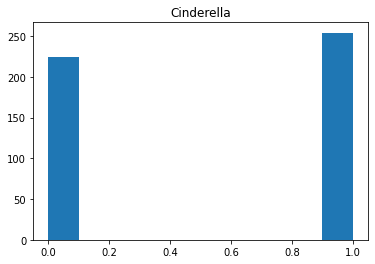

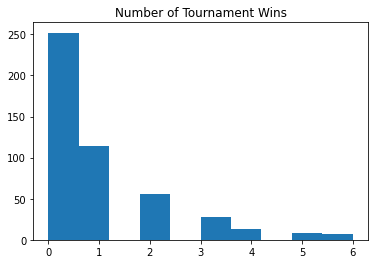

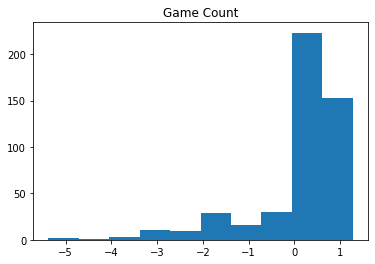

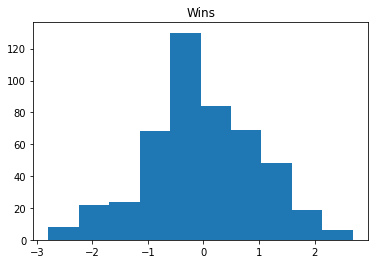

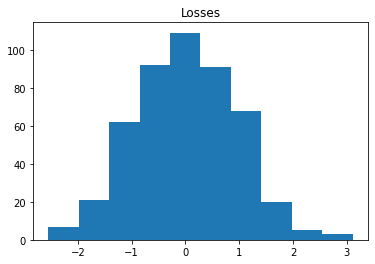

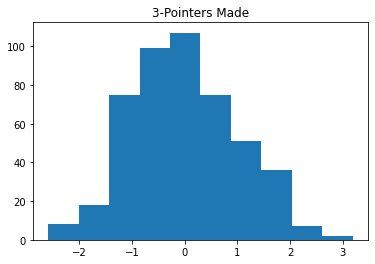

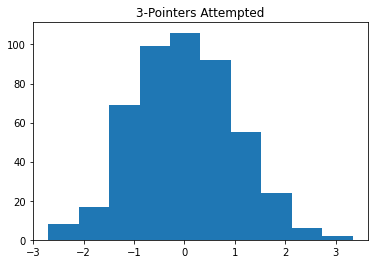

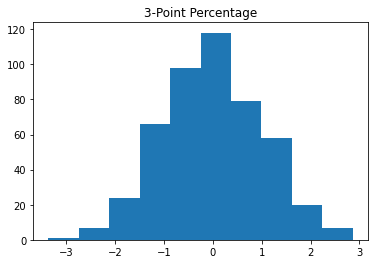

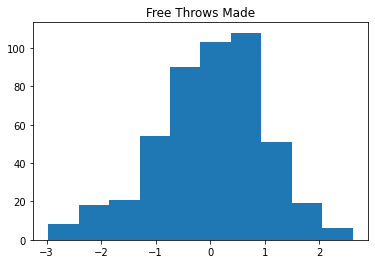

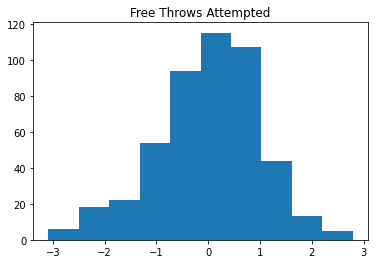

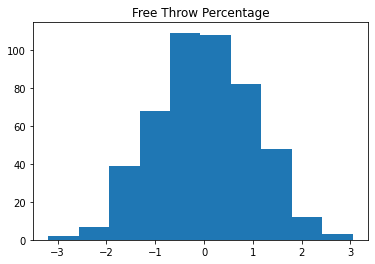

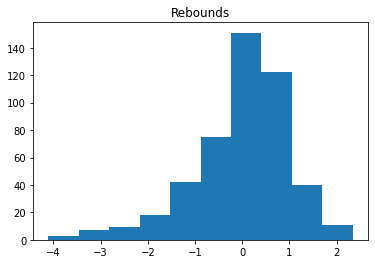

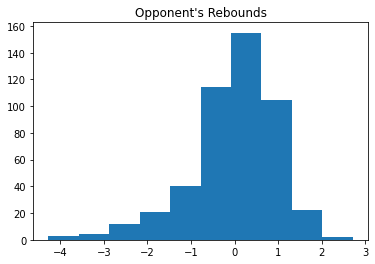

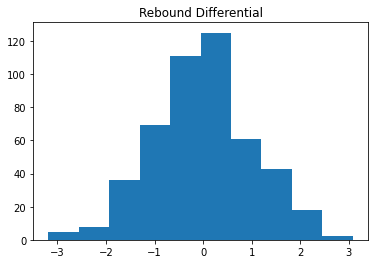

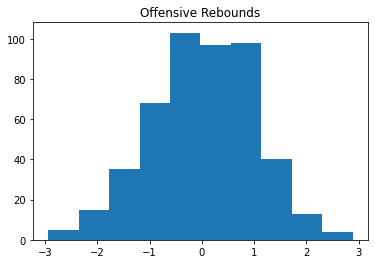

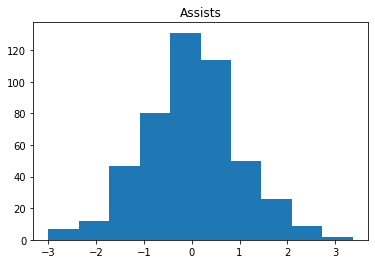

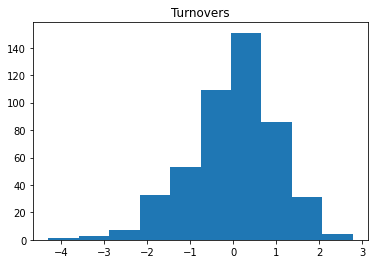

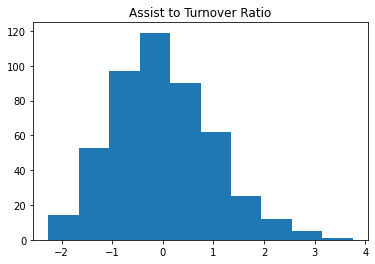

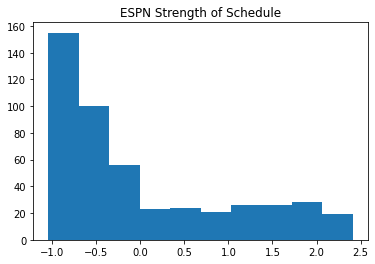

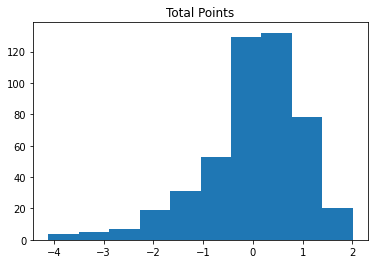

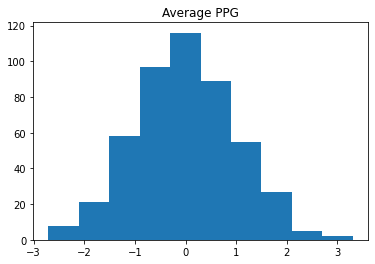

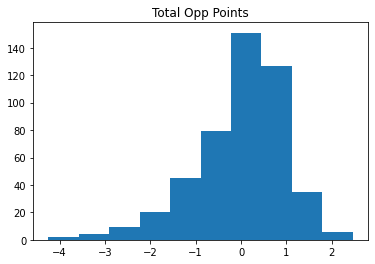

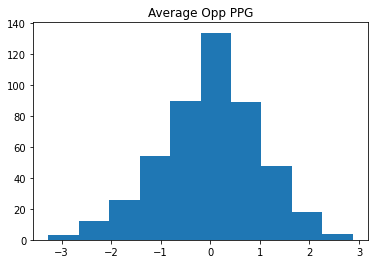

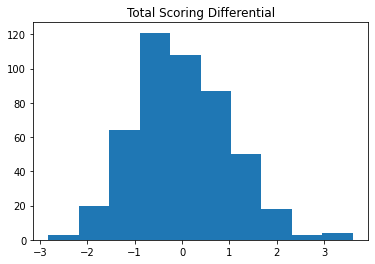

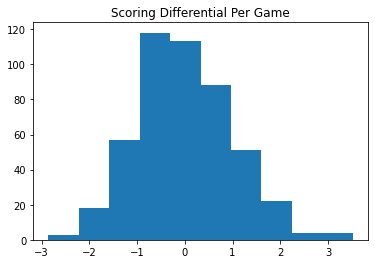

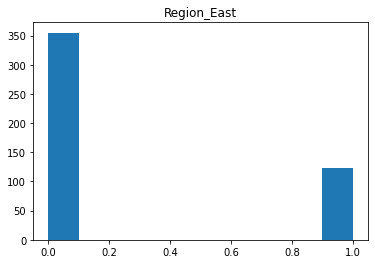

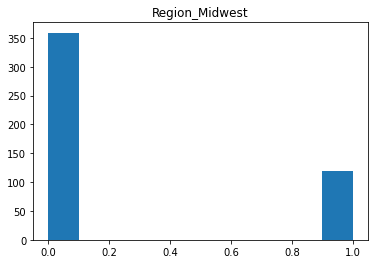

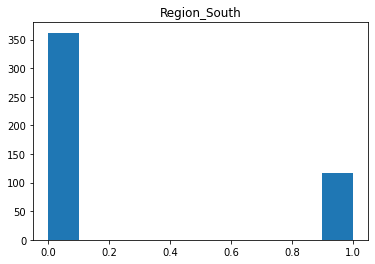

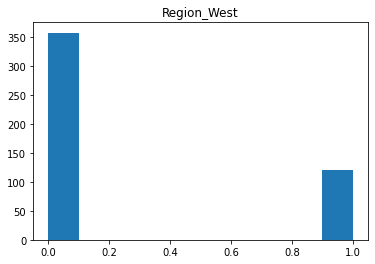

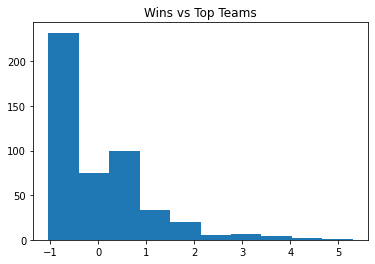

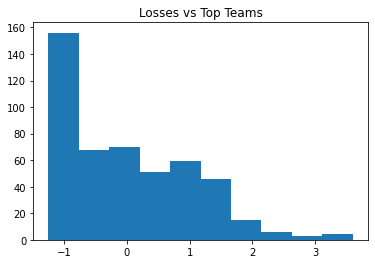

In [262]:
# look at distributions for each column
for c in df.columns:
    plt.hist(df[c])
    plt.title(c)
    plt.show()

In [264]:
# Use PCA to combine related features
combinations={
    "3pt":['3-Pointers Made','3-Pointers Attempted','3-Point Percentage'],
    "Free Throw-Rebound":['Free Throws Made','Free Throws Attempted','Free Throw Percentage','Rebounds',"Opponent's Rebounds","Rebound Differential","Offensive Rebounds"],
    "Region":['Region_East','Region_Midwest','Region_South','Region_West'],
    "PPG":['Total Points', 'Average PPG', 'Total Opp Points', 'Average Opp PPG'],
    "Scoring Differential":['Total Scoring Differential','Scoring Differential Per Game'],
    "Assist":['Assists', 'Assist to Turnover Ratio', 'Turnovers'],
    "Schedule":['ESPN Strength of Schedule', 'Wins vs Top Teams','Losses vs Top Teams'],
    "Win-Loss":['Game Count','Wins','Losses']
}

def create_pca(data: pd.DataFrame, columns: list, n_components=1, transform=False):
    """Create and return PCA model for given columns, transform in place if True"""
    pca = PCA(n_components).fit(data[columns])
    
    if transform:
        res = pd.DataFrame(pca.transform(data[columns]), columns=[f'{k}_{n}' for n in range(n_components)])
        data = data.join(res)

    return (pca, data)
# end def

pca_dict = dict()

for k in combinations.keys():
    res = create_pca(data=df, columns=combinations[k], n_components=1, transform=True)
    pca_dict[k] = res[0]
    df = res[1]
    df.drop(columns = combinations[k], inplace=True)

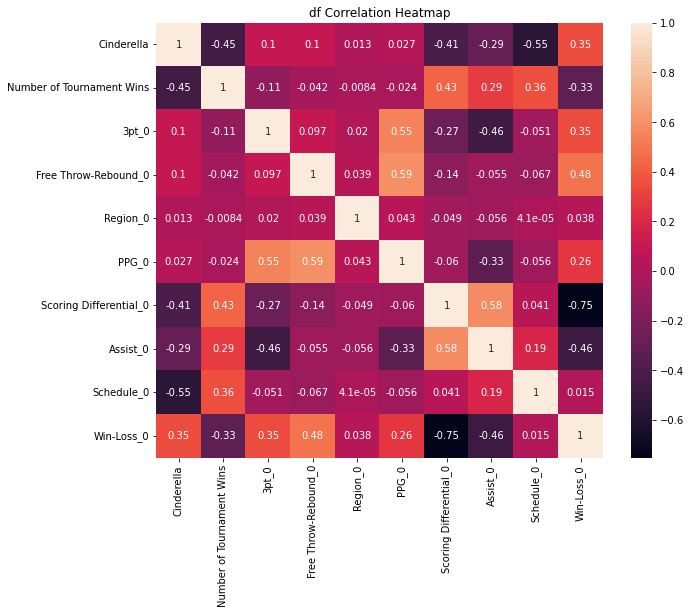

In [267]:
# find features with high collinearity
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True)
plt.title("df Correlation Heatmap")
plt.show()

## Validate Results

- Want to pick several Cinderella teams for bottom 4-6 predictions
